In [210]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import random as rd

In [211]:
def get_distance(x1, x2):
    sum = 0
    for i in range(len(x1)):
        sum += (x1[i] - x2[i]) ** 2
    return np.sqrt(sum)


def kmeans(X, k, max_iters):
  
    centroids = X[np.random.choice(range(len(X)), k, replace=False)]

    converged = False
    
    current_iter = 0

    while (not converged) and (current_iter < max_iters):

        cluster_list = [[] for i in range(len(centroids))]

        for x in X:  # Go through each data point
            distances_list = []
            for c in centroids:
                distances_list.append(get_distance(c, x))
            cluster_list[int(np.argmin(distances_list))].append(x)

        cluster_list = list((filter(None, cluster_list)))

        prev_centroids = centroids.copy()

        centroids = []

        for j in range(len(cluster_list)):
            centroids.append(np.mean(cluster_list[j], axis=0))

        pattern = np.abs(np.sum(prev_centroids) - np.sum(centroids))

        # print('K-MEANS: ', int(pattern))

        converged = (pattern == 0)

        current_iter += 1

    return np.array(centroids), [np.std(x) for x in cluster_list]

In [212]:
class RBF:

    def __init__(self, X, y, tX, ty, num_of_classes,
                 k, std_from_clusters=True):
        self.X = X
        self.y = y

        self.tX = tX
        self.ty = ty

        self.number_of_classes = num_of_classes
        self.k = k
        self.std_from_clusters = std_from_clusters

    def convert_to_one_hot(self, x, num_of_classes):
        arr = np.zeros((len(x), num_of_classes))
        for i in range(len(x)):
            c = int(x[i])
            arr[i][c] = 1
        return arr

    def rbf(self, x, c, s):
        distance = get_distance(x, c)
        return 1 / np.exp(-distance / s ** 2)

    def rbf_list(self, X, centroids, std_list):
        RBF_list = []
        for x in X:
            RBF_list.append([self.rbf(x, c, s) for (c, s) in zip(centroids, std_list)])
        return np.array(RBF_list)

    def fit(self):

        self.centroids, self.std_list = kmeans(self.X, self.k, max_iters=100)

        if not self.std_from_clusters:
            dMax = np.max([get_distance(c1, c2) for c1 in self.centroids for c2 in self.centroids])
            self.std_list = np.repeat(dMax / np.sqrt(2 * self.k), self.k)

        RBF_X = self.rbf_list(self.X, self.centroids, self.std_list)

        self.w = np.linalg.pinv(RBF_X.T @ RBF_X) @ RBF_X.T @ self.convert_to_one_hot(self.y, self.number_of_classes)

        RBF_list_tst = self.rbf_list(self.tX, self.centroids, self.std_list)

        self.pred_ty = RBF_list_tst @ self.w

        self.pred_ty = np.array([np.argmax(x) for x in self.pred_ty])

        diff = self.pred_ty - self.ty

        print('Accuracy: ', len(np.where(diff == 0)[0]) / len(diff))

        return self.pred_ty

In [213]:
data=pd.read_csv('EEG Eye State.csv')

In [214]:
columns_value = ['AF3',	'F7' ,'F3',	'FC5','T7',	'P7' ,'O1',	'O2','P8',	'T8' ,'FC6', 'F4 ','F8', 'AF4 ','eyeDetection']
dataset = data.values
dataset = pd.DataFrame(dataset,columns=columns_value)

In [215]:
print(dataset.head())

       AF3       F7       F3      FC5       T7       P7       O1       O2  \
0  4324.62  4004.62  4293.85  4148.72  4342.05  4586.67  4097.44  4638.97   
1  4327.69  4006.67  4295.38  4156.41  4336.92  4583.59  4096.92  4630.26   
2  4328.72  4011.79  4296.41  4155.90  4343.59  4582.56  4097.44  4630.77   
3  4326.15  4011.79  4292.31  4151.28  4347.69  4586.67  4095.90  4627.69   
4  4321.03  4004.62  4284.10  4153.33  4345.64  4587.18  4093.33  4616.92   

        P8       T8      FC6      F4        F8     AF4   eyeDetection  
0  4210.77  4226.67  4207.69  4279.49  4632.82  4384.10           0.0  
1  4207.69  4222.05  4206.67  4282.05  4628.72  4389.23           0.0  
2  4217.44  4235.38  4210.77  4287.69  4632.31  4396.41           0.0  
3  4210.77  4244.10  4212.82  4288.21  4632.82  4398.46           0.0  
4  4202.56  4232.82  4209.74  4281.03  4628.21  4389.74           0.0  


In [216]:
print(dataset.describe())

                 AF3            F7            F3            FC5            T7  \
count   14979.000000  14979.000000  14979.000000   14979.000000  14979.000000   
mean     4321.917289   4009.767729   4264.020750    4164.947444   4341.740507   
std      2492.155363     45.943206     44.429057    5216.578763     34.739911   
min      1030.770000   2830.770000   1040.000000    2453.330000   2089.740000   
25%      4280.510000   3990.770000   4250.260000    4108.210000   4331.790000   
50%      4294.360000   4005.640000   4262.560000    4120.510000   4338.970000   
75%      4311.790000   4023.080000   4270.770000    4132.310000   4347.180000   
max    309231.000000   7804.620000   6880.510000  642564.000000   6474.360000   

                  P7             O1            O2             P8  \
count   14979.000000   14979.000000  14979.000000   14979.000000   
mean     4644.026243    4110.401059   4616.055237    4218.826395   
std      2924.887134    4601.080128     29.292870    2136.479840  

In [217]:
print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14979 entries, 0 to 14978
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   AF3           14979 non-null  float64
 1   F7            14979 non-null  float64
 2   F3            14979 non-null  float64
 3   FC5           14979 non-null  float64
 4   T7            14979 non-null  float64
 5   P7            14979 non-null  float64
 6   O1            14979 non-null  float64
 7   O2            14979 non-null  float64
 8   P8            14979 non-null  float64
 9   T8            14979 non-null  float64
 10  FC6           14979 non-null  float64
 11  F4            14979 non-null  float64
 12  F8            14979 non-null  float64
 13  AF4           14979 non-null  float64
 14  eyeDetection  14979 non-null  float64
dtypes: float64(15)
memory usage: 1.7 MB
None


In [218]:
# Shuffle your dataset 
shuffle_df = dataset.sample(frac=1)

shuffle_df = shuffle_df.reset_index(drop=True)
shuffle_df

# store the labels into a variable y
# y = shuffle_df['target']

y = shuffle_df['eyeDetection']


# store the pixel data in X
X = shuffle_df.drop("eyeDetection", axis = 1)


# normalize the iris data 
X  = ((X - X.mean()) / (X.std()))
X= X.values

    

split = int(X.shape[0] * 0.80)
train_x, test_x, train_y, test_y = X[:split], X[split:], y[:split], y[split:]

In [219]:
#after scaled
X[:5]

array([[-7.69329593e-04, -1.56883468e-01,  8.25867236e-02,
        -1.14667959e-02, -2.71460304e-01, -1.04948469e-02,
        -1.09541799e-02, -5.78719889e-02, -4.96910608e-03,
        -1.43414496e-02, -1.07526124e-02,  3.07447219e-02,
        -6.98400199e-04, -6.79410415e-03],
       [-1.70243354e-02,  4.40167479e-02, -6.09978048e-01,
        -1.10738180e-02, -5.66797850e-01, -1.50522877e-02,
        -1.02847719e-02, -5.78719889e-02, -1.76909673e-02,
        -4.45591969e-01, -1.60009606e-01, -4.75204185e-01,
        -1.97978735e-02, -1.45408820e-02],
       [-1.74376323e-02, -7.81785441e-01, -4.02231125e-01,
        -9.10701169e-03,  6.79188070e-02, -3.83134194e-03,
        -6.27267048e-03,  4.49760068e-01, -5.93330895e-03,
        -2.16432644e-01, -3.22763244e-01, -5.37063780e-01,
        -1.89455140e-02, -1.29742133e-02],
       [-5.29553216e-03, -4.69225625e-01,  3.94319648e-01,
        -6.45393184e-03, -6.84817727e-01, -5.40747113e-03,
        -8.83728567e-03,  3.44615029e-01, -1.

In [207]:
RBF_CLASSIFIER = RBF(train_x, train_y, test_x, test_y, num_of_classes=2,
                     k=10, std_from_clusters=False)

pred_ty=RBF_CLASSIFIER.fit()

Accuracy:  0.5957943925233645


In [208]:
print("Test Y     :",test_y)
print("Predicted Y:",pred_ty)

Test Y     : 11983    0.0
11984    0.0
11985    1.0
11986    0.0
11987    0.0
        ... 
14974    0.0
14975    1.0
14976    1.0
14977    0.0
14978    0.0
Name: eyeDetection, Length: 2996, dtype: float64
Predicted Y: [0 0 1 ... 0 0 0]


Text(0.5, 1.0, 'Predicted')

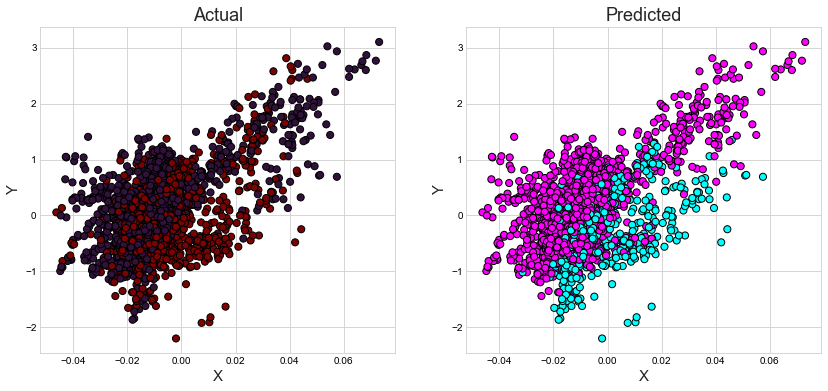

In [209]:
# Plot the identified clusters and compare with the answers
sns.set_style("whitegrid");
fig, axes = plt.subplots(1, 2, figsize=(14,6))
axes[0].scatter(test_x[:, 0], test_x[:, 1], c=test_y, cmap='turbo', edgecolor='k', s=50)
axes[1].scatter(test_x[:, 0], test_x[:, 1], c=pred_ty, cmap='cool_r', edgecolor='k', s=50)
axes[0].set_xlabel('X', fontsize=15)
axes[0].set_ylabel('Y', fontsize=15)
axes[1].set_xlabel('X', fontsize=15)
axes[1].set_ylabel('Y', fontsize=15)
axes[0].tick_params(direction='in', length=10, width=5, colors='k', labelsize=10)
axes[1].tick_params(direction='in', length=10, width=5, colors='k', labelsize=10)
axes[0].set_title('Actual', fontsize=18)
axes[1].set_title('Predicted', fontsize=18)